In [1]:
import uproot as upr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
from ROOT import vector, RDataFrame, RDF, TFile, TH1F, TH2F, gInterpreter, TMath
from src.general.utils import toVector, get_files, prep_filelist
from time import perf_counter

Welcome to JupyROOT 6.22/09


In [2]:
#GenPart_pdgId, GenPart_pt, and GenPart_statusFlags bit 7 or 8

In [3]:
#set up metadata for files
era = '2016'
deepflavour = False
deepcsv = True
extras = False
csv_v_flavor=False
if era == "2016":
    fname = "samplesCR_2016_Apr2020.yml"
    bDiscValue = 0.3093
if era == "2017":
    fname = "samplesCR_2017_Apr2020.yml"
    bDiscValue = 0.3033
if era == "2018":
    fname = "samplesCR_2018_Apr2020.yml"
    bDiscValue = 0.2770


sampleDir = "samples"
outname = fname.replace('.yml','.root')
fname = "{}/{}".format(sampleDir, fname)
outname, fname

('samplesCR_2016_Apr2020.root', 'samples/samplesCR_2016_Apr2020.yml')

In [4]:
sample_path ='/eos/cms/store/group/phys_exotica/bffZprime/nanoAODskimmed/crab_bffv2/{}/{{}}'.format(era)
eff_path ='/eos/cms/store/group/phys_exotica/bffZprime/nanoAODskimmed/crab_bff_eff/{}/{{}}'.format(era)

class sample_processor():
    '''Class that takes file name from yml and helps manage samples.'''
    def __init__(self,file_name,outname,bDiscValue,is_inclusive=0):
        #load config
        self.file_name = file_name
        with open(file_name,'r') as f:
            self.sample_dict = yaml.load(f, Loader=yaml.FullLoader)
        #setup outfile
        self.outname = outname
        self.out = TFile(outname, 'recreate')
        self.outdirs_dict = {}
        for sample in self.samples():
            name = sample['name']
            self.outdirs_dict[name] = self.out.mkdir(name)
        self.lumi = self.sample_dict['lumi']
        #get and write lumi info
        hlumi = TH1F("lumi", "lumi", 1, 0, 1)
        hlumi.SetDirectory(self.out)
        hlumi.SetBinContent(1, self.lumi)
        hlumi.Write()
        self.bDiscValue = bDiscValue
        self.is_inclusive = is_inclusive
    def samples(self):
        return self.sample_dict['samples']
    def sample_names(self):
        return [s['name'] for s in self.samples()]
    def close(self):
        self.out.Close()
    def __repr__(self):
        text_dict = {"fn":self.file_name,
                     "on":self.outname, 
                     "lumi":self.lumi,
                    "samples": self.sample_names()}
        return '''from {fn} to {on}\nlumi: {lumi}\nSamples {samples}'''.format(**text_dict)

In [5]:
sp = sample_processor(fname, outname, bDiscValue)

In [66]:
def check_bitwise(value, n):
    return value & (1 << n)== 1 << n
def hard_process(value):
    return (check_bitwise(value, 7) or check_bitwise(value, 8)) 

def b_jet(value):
    return abs(value)==5

def s_jet(value):
    return abs(value)==3

def gluon(value):
    return abs(value)==21

def min_phi(phi1, phi2):
    diff = (phi1-phi2 + 3.1415) % (2 * 3.1415) - 3.1415
    if diff < - 3.1415:
        return diff + 3.1415*2
    return diff

def deltaR_row(row1, row2):
    return deltaR(row1.GenPart_eta, row2.GenPart_eta, row1.GenPart_phi, row2.GenPart_phi)

def deltaR(eta1, eta2, phi1, phi2):
    return ((eta1-eta2)**2+ min_phi(phi1, phi2)**2)**.5


def is_in_list(arr, row, tdf):
    for i in arr:
        row2 = tdf.loc[i]
        if row2.GenPart_pdgId != row.GenPart_pdgId: continue
        dr = deltaR_row(row2, row)
        if dr <= .4: return True
    return False


def find_duplicates(_tdf):
    part_filter = []
    particles = []
    for i, row in _tdf.iterrows():
        accounted_for = is_in_list(particles, row, _tdf)
        if not accounted_for: particles.append(i)
        part_filter.append(not accounted_for)
    return part_filter

def return_jet_multiplicty(nevents):
    event = df.loc[nevents]
    ishardprocess_flag = event.GenPart_statusFlags.apply(hard_process)
    event = event[ishardprocess_flag]
    initial = event[event.GenPart_pt==0]
    
    outgoing = event[event.GenPart_pt>0]
    
    ishardprocess_flag = outgoing.GenPart_statusFlags.apply(hard_process)
    ishardprocess = outgoing[ishardprocess_flag]
    dedupe = find_duplicates(ishardprocess)
    ishardprocess = ishardprocess[dedupe]
    isbjet = ishardprocess.GenPart_pdgId.apply(b_jet)
    issjet = ishardprocess.GenPart_pdgId.apply(s_jet)
    b_and_s_jets = ishardprocess[isbjet|issjet]
    b_and_s_jets = b_and_s_jets.sort_values("GenPart_pt")
    highestpt_bplus = 0
    highestpt_bminus = 0
    highestpt_s = 0
    for i, part in b_and_s_jets.iterrows():
        pdgid = part.GenPart_pdgId
        pt = part.GenPart_pt
        if (pdgid==5) and (pt>highestpt_bplus):  highestpt_bplus=pt
        if (pdgid==-5) and (pt>highestpt_bminus):  highestpt_bminus=pt
        if (abs(pdgid)==3) and (pt>highestpt_s):  highestpt_s=pt
    
    highestpt_b = max(highestpt_bplus, highestpt_bminus)
    
    nbjet = isbjet.sum()
    nsjet = issjet.sum()

    #initial :
    inbjet = initial.GenPart_pdgId.apply(b_jet).sum()
    insjet = initial.GenPart_pdgId.apply(s_jet).sum()
    ingluon = initial.GenPart_pdgId.apply(gluon).sum()
    
    # 0j: 0
    # 1b: 1
    # 1s: 2
    # 1b+1s: 3
    # 2b: 4
    # other: -1
    multiplicity=-1
    if (inbjet==2) and (insjet==0) and (ingluon==0): multiplicity=0
    if (inbjet==1) and (insjet==1) and (ingluon==0): multiplicity=0
    if (inbjet==0) and (insjet==1) and (ingluon==1): multiplicity=1
    #differentiate between 1b and 1s in 5 21 initial state:
    if (inbjet==1) and (insjet==0) and (ingluon==1): 
        if highestpt_b > highestpt_s: multiplicity=1
        if highestpt_s > highestpt_b: multiplicity=2
    if (inbjet==0) and (insjet==0) and (ingluon==2):
        if ((highestpt_s > highestpt_bplus) or (highestpt_s > highestpt_bminus)) and highestpt_b > 0: multiplicity=3
        if ((highestpt_bplus > highestpt_s) and (highestpt_bminus > highestpt_s)): multiplicity=4
    return {"GenNbJets": nbjet, "GenNsJets": nsjet, 
            "inbjet":inbjet, "insjet":insjet, "ingluon": ingluon,
            "nGenPart": len(event), "multiplicity": multiplicity}

In [114]:
def make_dataframe():

    njets = []
    start = perf_counter()
    nevents = len(events)
    nevents = 1000
    for i in range(nevents):
        current = perf_counter()
        if i % 100==0: 
            print(i, i/nevents)
            if i > 0:
                td = current-start
                nsteps = i/int(100)
                tps = td/nsteps
                steps_remaining = nevents/100 - nsteps
                time_remaining =  tps*steps_remaining
                print(current-start, nsteps, time_remaining)

        njets.append(return_jet_multiplicty(i))
    jet_df = pd.DataFrame(njets)
    return jet_df

In [68]:
files = {
    #0.04: '/eos/cms/store/group/phys_exotica/bffZprime/private_samples/signal/2016_NanoAODv6/BFFZprimeToMuMu_M200p0_dbs_0p04_2016/BFFZprimeToMuMu_M200p0_dbs_0p04_2016.root',
    1.0: '/eos/cms/store/group/phys_exotica/bffZprime/private_samples/signal/2016_NanoAODv6/BFFZprimeToMuMu_M200p0_dbs_1p0_2016/BFFZprimeToMuMu_M200p0_dbs_1p0_2016.root',
    .5: "/eos/cms/store/group/phys_exotica/bffZprime/private_samples/signal/2016_NanoAODv6/BFFZprimeToMuMu_M200p0_dbs_1p0_2016/BFFZprimeToMuMu_M200p0_dbs_1p0_2016.root"
}    

In [69]:
for dbs, file in files.items():
    print(dbs)
    events = upr.open(file)['Events']
    df = events.arrays(['GenPart_pdgId',  'GenPart_statusFlags', 'GenPart_pt', 'GenPart_eta', 'GenPart_phi'], library='pd')
    jet_df = make_dataframe()
    break

1.0
0 0.0
100 0.1
3.0410962940659374 1.0 27.369866646593437
200 0.2
5.888414895161986 2.0 23.553659580647945
300 0.3
8.598499185172841 3.0 20.063164765403293
400 0.4
11.352291719056666 4.0 17.028437578585
500 0.5
14.247386339120567 5.0 14.247386339120567
600 0.6
17.05074504110962 6.0 11.367163360739747
700 0.7
19.846214949153364 7.0 8.505520692494299
800 0.8
22.53111839410849 8.0 5.632779598527122
900 0.9
25.313539595110342 9.0 2.8126155105678157


array([0.005, 0.864, 0.1  , 0.024, 0.004, 0.003])

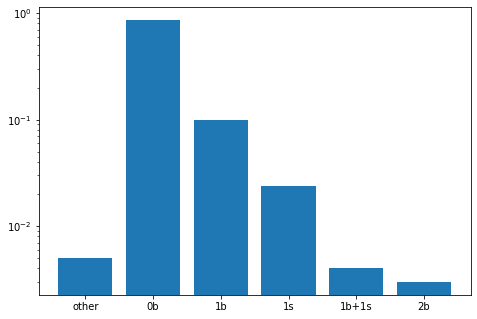

In [70]:
hist  = np.histogram(jet_df.multiplicity, bins=np.linspace(-1.5, 4.5, 7), density=True)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['C', 'C++', 'Java', 'Python', 'PHP']
students = [23,17,35,29,12]
ax.bar(['other', '0b', '1b', '1s', '1b+1s', '2b'], hist[0])

plt.yscale('log')
hist[0]

In [71]:
jet_df[jet_df.multiplicity==-1]

,GenNbJets,GenNsJets,inbjet,insjet,ingluon,nGenPart,multiplicity
83,2,0,1,0,0,10,-1
281,2,0,0,1,0,11,-1
314,2,0,0,1,0,15,-1
484,1,0,1,0,0,10,-1
780,1,0,0,1,0,13,-1


In [65]:
bin(20481), bin(10625), bin(4481)

('0b101000000000001', '0b10100110000001', '0b1000110000001')

In [62]:
check_bitwise(10625, 0), check_bitwise(4481, 0), check_bitwise(20481, 0)

(True, True, True)

In [89]:
event = df.loc[281]
initial = event[event.GenPart_pt==0]

outgoing = event[event.GenPart_pt>0]
ishardprocess_flag = outgoing.GenPart_statusFlags.apply(hard_process)
ishardprocess = outgoing[ishardprocess_flag]
dedupe = find_duplicates(ishardprocess)
ishardprocess = ishardprocess[dedupe]
initial

,GenPart_pdgId,GenPart_statusFlags,GenPart_pt,GenPart_eta,GenPart_phi
subentry,,,,,
0,3,10625,0.0,23040.0,0.0
1,1,2433,0.0,-24128.0,0.0


In [87]:
ishardprocess

,GenPart_pdgId,GenPart_statusFlags,GenPart_pt,GenPart_eta,GenPart_phi
subentry,,,,,
2,32,4481,81.0000,1.308594,1.210938
3,1,385,67.2500,-3.671875,-0.947266
4,5,4481,71.0000,0.822266,-2.835938
7,-13,12673,42.7500,-0.886719,2.335938
8,13,12673,73.5000,1.621094,0.617188
9,1,8449,43.3750,-3.195312,-0.544922
11,5,8449,18.9375,0.539062,1.710938


In [90]:
event

,GenPart_pdgId,GenPart_statusFlags,GenPart_pt,GenPart_eta,GenPart_phi
subentry,,,,,
0,3,10625,0.000000,23040.000000,0.000000
1,1,2433,0.000000,-24128.000000,0.000000
2,32,4481,81.000000,1.308594,1.210938
3,1,385,67.250000,-3.671875,-0.947266
4,5,4481,71.000000,0.822266,-2.835938
5,5,18689,70.250000,0.775391,-2.835938
6,32,10497,79.500000,1.304688,1.179688
7,-13,12673,42.750000,-0.886719,2.335938
8,13,12673,73.500000,1.621094,0.617188


In [66]:
(check_bitwise(8193, 7), check_bitwise(8193, 8)),  (check_bitwise(8193, 13))

((False, False), True)

In [91]:
jet_df[jet_df.multiplicity==-1]

,GenNbJets,GenNsJets,inbjet,insjet,ingluon,nGenPart,multiplicity
83,2,0,1,0,0,36,-1
139,2,0,1,0,1,60,-1
241,0,2,1,0,1,19,-1
281,2,0,0,1,0,26,-1
314,2,0,0,1,0,40,-1
429,3,0,0,0,2,55,-1
470,2,0,0,1,1,25,-1
471,0,2,1,0,1,21,-1
482,2,0,1,0,1,44,-1
484,1,0,1,0,0,37,-1


In [34]:
return_jet_multiplicty(22)

{'GenNbJets': 1,
 'GenNsJets': 0,
 'inbjet': 0,
 'insjet': 1,
 'ingluon': 1,
 'nGenPart': 41,
 'multiplicity': 1}

1.0
0 0.0
100 0.1
5.85965865093749 1.0 52.73692785843741
200 0.2
11.624140353989787 2.0 46.49656141595915
300 0.3
17.421452365932055 3.0 40.65005552050813
400 0.4
23.28423595498316 4.0 34.92635393247474
500 0.5
29.170991439954378 5.0 29.170991439954378
600 0.6
35.81793945096433 6.0 23.87862630064289
700 0.7
42.09903660102282 7.0 18.04244425758121
800 0.8
48.306245840969495 8.0 12.076561460242374
900 0.9
54.95153093500994 9.0 6.105725659445549


Text(0.5, 1.0, 'before selection')

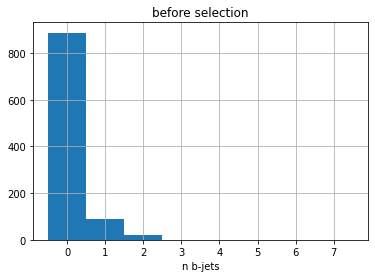

In [81]:
jet_df.GenNbJets.hist(bins=np.linspace(-.5,7.5, 9))
plt.xlabel('n b-jets')
plt.title('before selection')

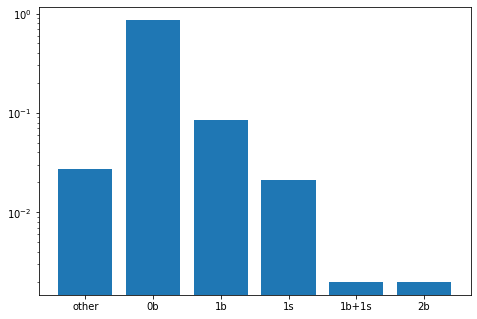

In [90]:
hist  = np.histogram(jet_df.multiplicity, bins=np.linspace(-1.5, 4.5, 7), density=True)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['C', 'C++', 'Java', 'Python', 'PHP']
students = [23,17,35,29,12]
ax.bar(['other', '0b', '1b', '1s', '1b+1s', '2b'], hist[0])

plt.yscale('log')


In [86]:
hist

(array([0.027, 0.863, 0.085, 0.021, 0.002, 0.002]),
 array([-1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5]))

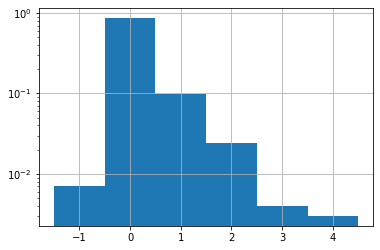

In [68]:
jet_df.multiplicity.hist(bins=np.linspace(-1.5, 4.5, 7), density=True)
plt.yscale('log')


Text(0.5, 1.0, 'before selection')

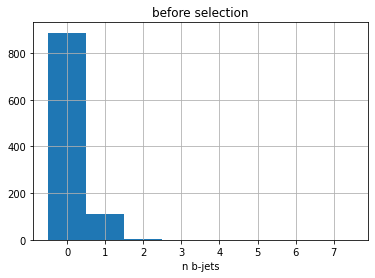

In [71]:
jet_df.GenNbJets.hist(bins=np.linspace(-.5,7.5, 9))
plt.xlabel('n b-jets')
plt.title('before selection')

Text(0.5, 1.0, 'before selection')

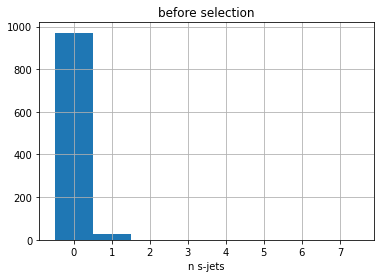

In [72]:
jet_df.GenNsJets.hist(bins=np.linspace(-.5,7.5, 9))
plt.xlabel('n s-jets')
plt.title('before selection')

In [135]:
hist = np.histogram(jet_df.GenNsJets, bins=np.linspace(-.5,7.5, 9))
hist[0]*25

array([121925, 121675,   5675,    600,    125,      0,      0,      0])

In [21]:
df.size

2000

In [115]:
for sample in sp.samples():
    name = sample['name']
    if not 'BFF' in name: continue
    if not '200' in name: continue
    if not '0p5' in name: continue
    files_df = get_files(sample['fileglob'], sample_path)
    file = files_df.file.iloc[0]
    events = upr.open(file)['Events']
    df = events.arrays(['GenPart_pdgId',  'GenPart_statusFlags', 'GenPart_pt', 'GenPart_eta', 'GenPart_phi'], library='pd')
    jet_df = make_dataframe()

0 0.0
100 0.1
0.9888323929626495 1.0 8.899491536663845
200 0.2
2.040161535842344 2.0 8.160646143369377
300 0.3
3.019882910884917 3.0 7.0463934587314725
400 0.4
4.080772898858413 4.0 6.12115934828762
500 0.5
5.059307551942766 5.0 5.059307551942766
600 0.6
6.072761272778735 6.0 4.048507515185823
700 0.7
7.067556694848463 7.0 3.0289528692207703
800 0.8
8.070732423802838 8.0 2.0176831059507094
900 0.9
9.022719081956893 9.0 1.0025243424396548


array([0.005, 0.836, 0.135, 0.015, 0.003, 0.006])

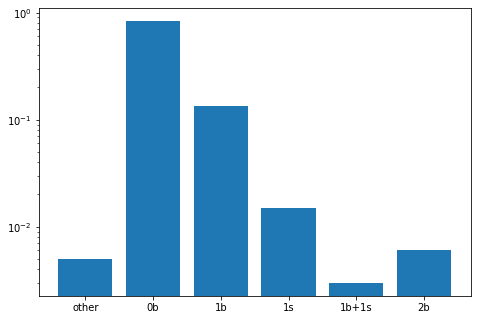

In [116]:
hist  = np.histogram(jet_df.multiplicity, bins=np.linspace(-1.5, 4.5, 7), density=True)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['C', 'C++', 'Java', 'Python', 'PHP']
students = [23,17,35,29,12]
ax.bar(['other', '0b', '1b', '1s', '1b+1s', '2b'], hist[0])

plt.yscale('log')
hist[0]

In [110]:
jet_df.iloc[8]

GenNbJets        1
GenNsJets        0
inbjet           1
insjet           0
ingluon          1
nGenPart        13
multiplicity     1
Name: 8, dtype: int64

In [111]:
df.loc[8]

,GenPart_pdgId,GenPart_statusFlags,GenPart_pt,GenPart_eta,GenPart_phi
subentry,,,,,
0,21,10625,0.000000,23104.000000,0.000000
1,-5,6529,0.000000,-23552.000000,0.000000
2,32,4481,433.000000,-0.931641,1.398438
3,-5,385,433.000000,0.015747,-1.742188
4,32,10497,435.000000,-0.933594,1.371094
5,-13,4481,194.500000,-0.519531,1.742188
6,13,22913,264.000000,-1.121094,1.101562
7,22,12289,12.750000,-1.125000,1.101562
8,-13,18689,194.500000,-0.519531,1.742188
